In [1]:
import torch
from torch.utils.data import DataLoader, random_split

import numpy as np
import matplotlib.pyplot as plt

from PINN import PINN
from Siren import HSiren
from GridDataset3D import GridDataset as G3D

generator = torch.Generator()
generator.manual_seed(42);

In [ ]:
dataset = G3D(dir="../../data/Case_01/measurements_flow/postProcessing_BL/winSpeedMapVector/",
            turbine_csv="../../data/Case_01/measurements_turbines/30000_BL/rot_yaw_combined.csv",
            wind_csv="../../data/Case_01/winDir_processed.csv", 
            data_type="wake", 
            wake_dir="../../data/Case_01/measurements_flow/postProcessing_LuT2deg_internal/winSpeedMapVector/",
            wake_turbine_csv="../../data/Case_01/measurements_turbines/30000_LuT2deg_internal/rot_yaw_combined.csv",
            time_scaling_factor=1/9.6)

_, _, test = random_split(dataset, [0.7, 0.15, 0.15], generator=generator)

test_loader = DataLoader(test, batch_size=1, shuffle=True, num_workers=4)

len(test_loader)

360

## SiLU Wake Steering

In [3]:
epoch = 340
hidden_size = 256
physics_coef = 0.01
depth = 5

checkpoint = torch.load(f"D:/models2/SiLU{hidden_size}-d{depth}-p{physics_coef}-f/model{epoch}.pt")

checkpoint.keys()

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'train_losses', 'val_losses'])

In [9]:
best_epoch = np.argsort(checkpoint['val_losses']['total'])[0]+1

print(f"Best Epoch: {best_epoch} \nTrain Loss: {checkpoint['train_losses']['total'][best_epoch-1]*64:.4f} \nVal Loss: {checkpoint['val_losses']['total'][best_epoch-1]*64:.4f}")

Best Epoch: 335 
Train Loss: 0.2232 
Val Loss: 0.2235


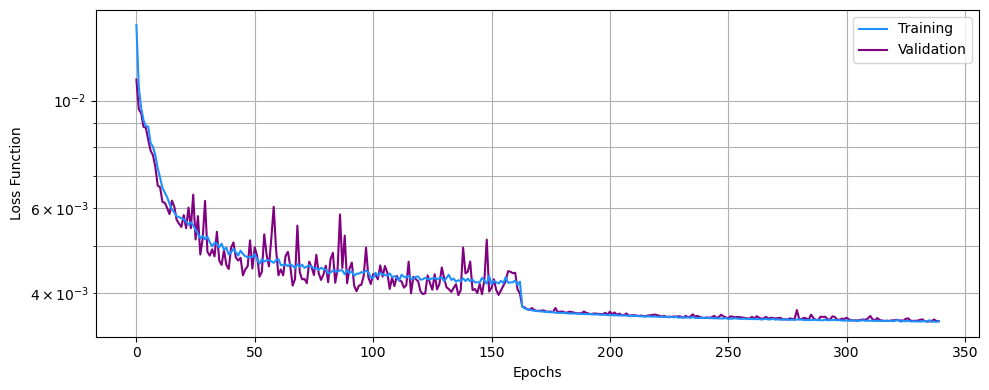

In [10]:
fig, ax = plt.subplots(figsize=(10,4))

ax.plot(checkpoint['train_losses']['total'], label="Training", zorder=3, color="dodgerblue")
ax.plot(checkpoint['val_losses']['total'], label="Validation", zorder=2, color="purple")

ax.set_xlabel("Epochs")
ax.set_ylabel("Loss Function")

ax.set_yscale("log")
ax.legend()
ax.grid(which="both")

fig.tight_layout()

In [ ]:
#Loading the model at the best epoch
checkpoint = torch.load(f"D:/models2/SiLU{hidden_size}-d{depth}-p{physics_coef}-f/model{best_epoch}.pt")

model = PINN(in_dimensions=26, hidden_size=hidden_size, out_dimensions=4)

model.load_state_dict(checkpoint['model_state_dict'])

model.cuda().eval();

In [14]:
target_fields = []
output_fields = []

with torch.no_grad():
    for inputs, targets in test_loader:        
        inputs = inputs.flatten(0, 1).float().cuda(non_blocking=True)
        targets = targets.flatten(0, 1).float().cuda(non_blocking=True) * 8
        
        outputs = model(inputs)[0] * 8

        target_fields.append(targets.reshape(300, 300, 3).detach().cpu())
        output_fields.append(outputs.reshape(300, 300, 4).detach().cpu())

targ_tensor = torch.stack(target_fields).flatten(0, 2) 
out_tensor = torch.stack(output_fields)[:, :, :, :3].flatten(0, 2) 
test_mse = torch.nn.functional.mse_loss(targ_tensor, out_tensor).item()

print(f"Test Loss: {test_mse:.4f} \nAverage Error: {test_mse**0.5:.3f} m/s")

Test Loss: 0.2200 
Average Error: 0.469 m/s


In [16]:
#Calculating magnitude of wind speed using x-y components
umean_pred = list(map(lambda x: torch.sqrt(x[:, :, 0]**2 + x[:, :, 1]**2), output_fields))
umean_field = list(map(lambda x: torch.sqrt(x[:, :, 0]**2 + x[:, :, 1]**2), target_fields))

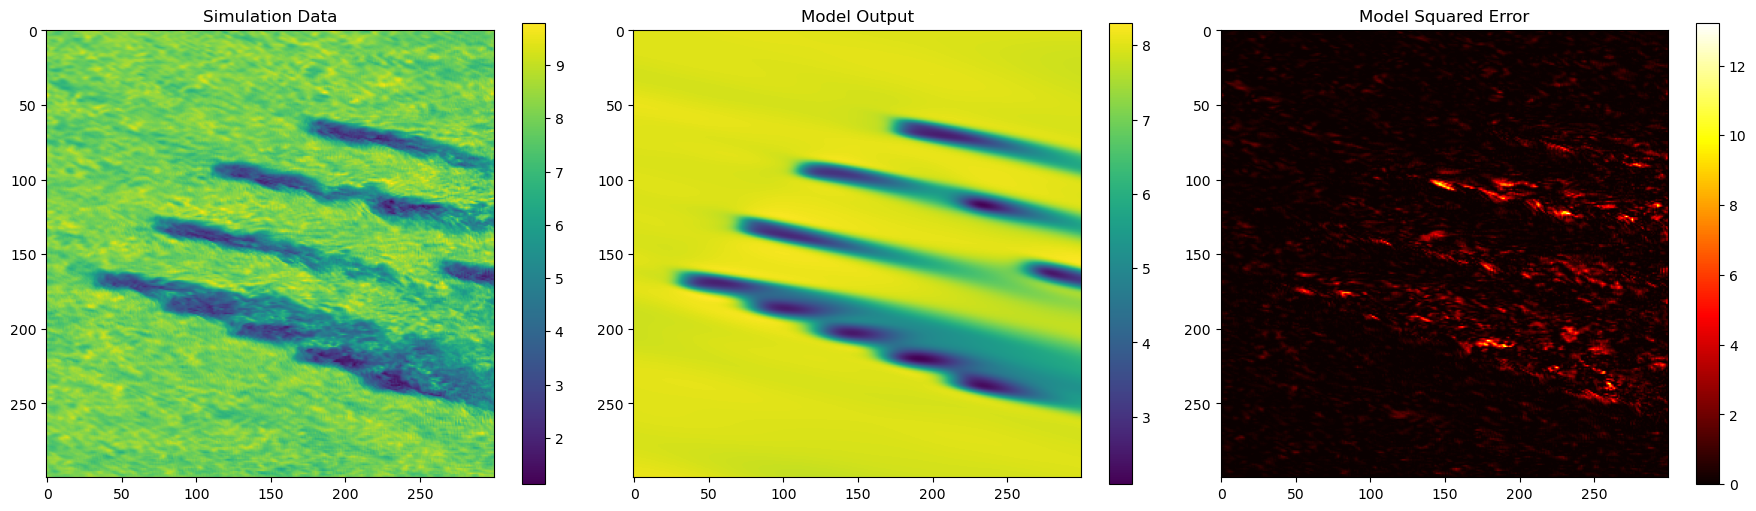

In [26]:
sample = 15

squared_error = (umean_pred[sample] - umean_field[sample]).pow(2)

fig, ax = plt.subplots(ncols=3, figsize=(18, 5))

im = ax[0].imshow(umean_field[sample])
fig.colorbar(im)
im = ax[1].imshow(umean_pred[sample])
fig.colorbar(im)
im = ax[2].imshow(squared_error, cmap='hot')
fig.colorbar(im)

ax[0].set_title("Simulation Data")
ax[1].set_title("Model Output")
ax[2].set_title("Model Squared Error")

fig.tight_layout()

## HSiren

In [38]:
epoch = 208
omega = 10
hidden_size = 256
physics_coef = 0.01

checkpoint = torch.load(f"D:/models2/HSiren{hidden_size}-w{omega}-p{physics_coef}-f/model{epoch}.pt")

best_epoch = np.argsort(checkpoint['val_losses']['total'])[0]+1
print(f"Best Epoch: {best_epoch} \nTrain Loss: {checkpoint['train_losses']['total'][best_epoch-1]*64:.4f} \nVal Loss: {checkpoint['val_losses']['total'][best_epoch-1]*64:.4f}")

Best Epoch: 200 
Train Loss: 0.2275 
Val Loss: 0.2262


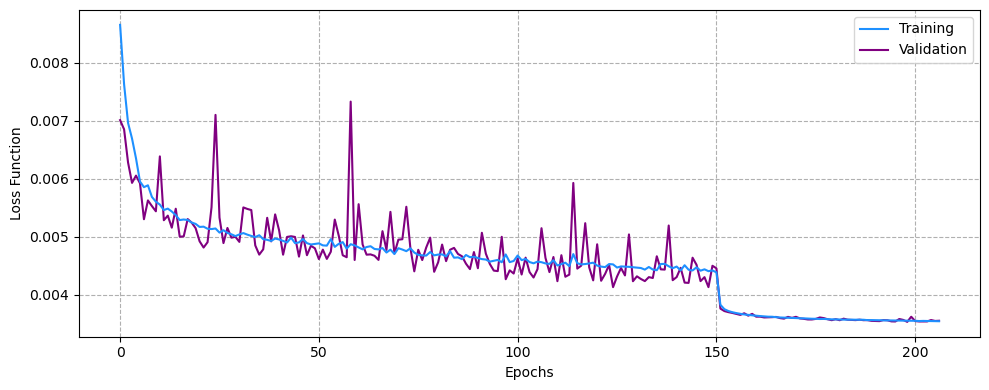

In [36]:
fig, ax = plt.subplots(figsize=(10,4))

ax.plot(checkpoint['train_losses']['total'][1:], label="Training", zorder=3, color="dodgerblue")

ax.plot(checkpoint['val_losses']['total'][1:], label="Validation", zorder=2, color="purple")

ax.legend()

# ax.set_yscale("log")
ax.grid(ls="--", which="both", zorder=0)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss Function")

fig.tight_layout()

In [41]:
model = HSiren(in_features=26, 
               hidden_features=hidden_size, 
               hidden_layers=5, 
               out_features=4, 
               outermost_linear=True,
               hidden_omega_0=omega).cuda()

checkpoint = torch.load(f"D:/models2/HSiren{hidden_size}-w{omega}-p{physics_coef}-f/model{best_epoch}.pt")

try:
    del checkpoint['model_state_dict']['density']
except:
    pass

model.load_state_dict(checkpoint['model_state_dict'])

model.cuda().eval();

In [43]:
target_fields = []
output_fields = []

with torch.no_grad():
    for inputs, targets in test_loader:        
        inputs = inputs.flatten(0, 1).float().cuda(non_blocking=True)
        targets = targets.flatten(0, 1).float().cuda(non_blocking=True) * 8

        outputs = model(inputs)[0] * 8

        target_fields.append(targets.reshape(300, 300, 3).detach().cpu())
        output_fields.append(outputs.reshape(300, 300, 4).detach().cpu())

targ_tensor = torch.stack(target_fields).flatten(0, 2) 
out_tensor = torch.stack(output_fields)[:, :, :, :3].flatten(0, 2) 
test_mse = torch.nn.functional.mse_loss(targ_tensor, out_tensor)

print(f"Test Loss: {test_mse:.4f} \nAverage Error: {test_mse**0.5:.3f} m/s")

Test Loss: 0.2187 
Average Error: 0.468 m/s


In [44]:
#Calculating magnitude of wind speed using x-y components
umean_pred = list(map(lambda x: torch.sqrt(x[:, :, 0]**2 + x[:, :, 1]**2), output_fields))
umean_field = list(map(lambda x: torch.sqrt(x[:, :, 0]**2 + x[:, :, 1]**2), target_fields))

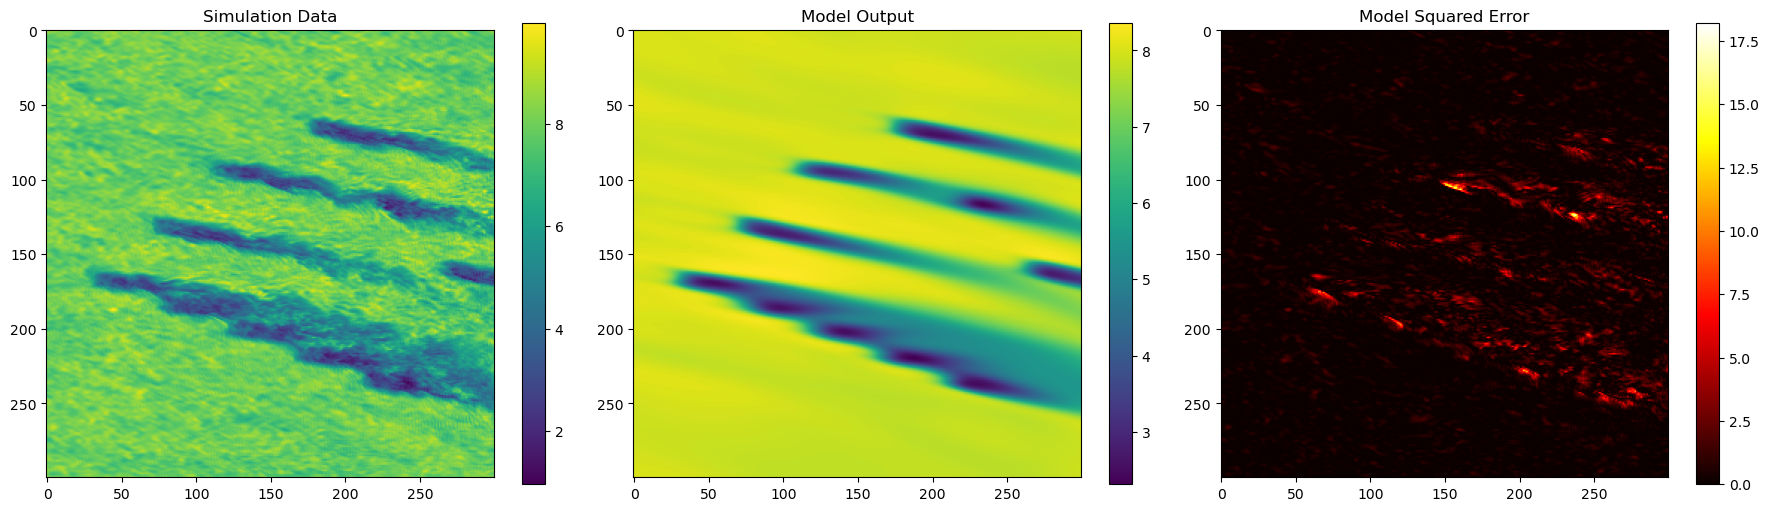

In [86]:
sample = 8

squared_error = (umean_pred[sample] - umean_field[sample]).pow(2)

fig, ax = plt.subplots(ncols=3, figsize=(18, 5))

im = ax[0].imshow(umean_field[sample])
fig.colorbar(im)
im = ax[1].imshow(umean_pred[sample])
fig.colorbar(im)
im = ax[2].imshow(squared_error, cmap='hot')
fig.colorbar(im)

ax[0].set_title("Simulation Data")
ax[1].set_title("Model Output")
ax[2].set_title("Model Squared Error")

fig.tight_layout()